This tutorial follows the context from the PyTorch website https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Load Cifar10 data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
# Load training data
trainset = torchvision.datasets.CIFAR10(root='/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Load testing data
testset = torchvision.datasets.CIFAR10(root='/data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=2)

# Classes: 10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


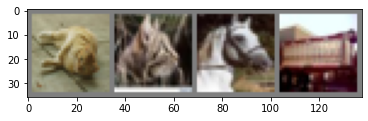

  cat   cat horse truck


In [12]:
# Training images
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # Unnomalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# shows images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Define a Convolutional Neural Network

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 because images in color RGB, 6 is output filters, 5 is conv size
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

net = Net()

# Loss Function and Optimizer

In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training the network

In [16]:
type(trainloader)

torch.utils.data.dataloader.DataLoader

In [25]:
# Loop over data iterator, feed the inputs to network and optimize
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print stats
        running_loss += loss.item()
        if i % 2000 == 1999: # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3df' %
                  (epoch + 1, i +1, running_loss / 2000))
            running_loss = 0.0
        
    print('Finished Training')

[1,  2000] loss: 001f
[1,  4000] loss: 001f
[1,  6000] loss: 001f
[1,  8000] loss: 001f
[1, 10000] loss: 001f
[1, 12000] loss: 001f
Finished Training
[2,  2000] loss: 001f
[2,  4000] loss: 001f
[2,  6000] loss: 001f
[2,  8000] loss: 001f
[2, 10000] loss: 001f
[2, 12000] loss: 001f
Finished Training


In [26]:
# Save trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH) #name_of_model.state_dict()
# loading trained model
# net = Net()
# net.load_state_dict(torch.load(PATH))

# Testing network on test data

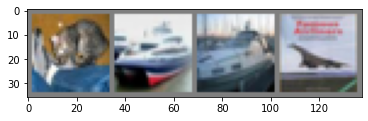

GroundTruth:    cat  ship  ship plane


In [27]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [30]:
# Make prediction with model
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                             for j in range(4)))

Predicted:    cat  ship  ship  ship


In [32]:
# Check performance on whole test dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on 10000 test images: %d %%' %(100*correct/total))

Accuracy on 10000 test images: 58 %


In [37]:
# Check which classes performed well and not so well
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d%%' %(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66%
Accuracy of   car : 58%
Accuracy of  bird : 33%
Accuracy of   cat : 49%
Accuracy of  deer : 35%
Accuracy of   dog : 40%
Accuracy of  frog : 75%
Accuracy of horse : 75%
Accuracy of  ship : 76%
Accuracy of truck : 75%


In [38]:
# Check GPU
device = torch.device("cuda: 0" if torch.cuda.is_available() else 'cpu')
print(device)

cpu
